In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

(2115, 22, 1000)


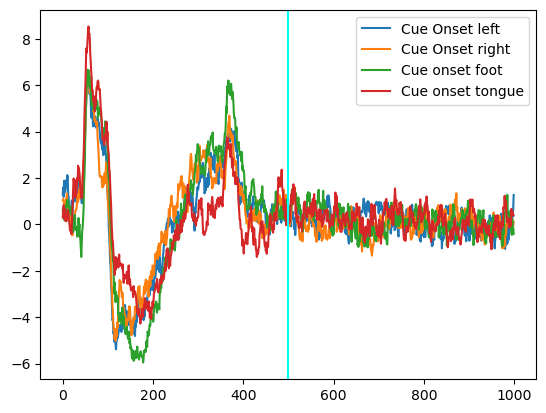

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

_=plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [3]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        print('Shape of X after subsampling:',X_subsample.shape)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming test:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling test:',total_X.shape)
    
    return total_X




In [4]:

## Random splitting

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
X_train, X_valid = X_train_valid[ind_train], X_train_valid[ind_valid] 
y_train, y_valid = y_train_valid[ind_train], y_train_valid[ind_valid]

## Preprocessing the dataset

x_train, y_train = train_data_prep(X_train, y_train, 2, 2, True)
x_valid, y_valid = train_data_prep(X_valid, y_valid, 2, 2, True)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
X_test_prep = test_data_prep(X_test)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (1615, 22, 800)
Shape of X after maxpooling: (1615, 22, 400)
Shape of X after averaging+noise and concatenating: (3230, 22, 400)
Shape of X after subsampling: (1615, 22, 400)
Shape of X after subsampling: (1615, 22, 400)
Shape of X after subsampling and concatenating: (6460, 22, 400)
Shape of Y: (6460,)
Shape of X after trimming: (500, 22, 800)
Shape of X after maxpooling: (500, 22, 400)
Shape of X after averaging+noise and concatenating: (1000, 22, 400)
Shape of X after subsampling: (500, 22, 400)
Shape of X after subsampling: (500, 22, 400)
Shape of X after subsampling and concatenating: (2000, 22, 400)
Shape of Y: (2000,)
Shape of training set: (6460, 22, 400)
Shape of validation set: (2000, 22, 400)
Shape of training labels: (6460,)
Shape of validation labels: (2000,)
Shape of X after trimming test: (443, 22, 800)
Shape of X after maxpooling test: (443, 22, 400)
Shape of training labels after categorical conversion: (6460, 4)
Shape of validation labels af

In [5]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten

# Building the model using sequential class
rnn_model = Sequential()

# Dense layer 1
rnn_model.add(Dense(25, activation='elu', input_shape=(400,1,22)))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.6))

# Dense layer 2
rnn_model.add(Dense(50, activation='elu'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.6))

# Dense layer 3
rnn_model.add(Dense(50, activation='elu'))
rnn_model.add(BatchNormalization())
rnn_model.add(Dropout(0.6))


# Flatten layer to flatten the last two dimensions
rnn_model.add(Flatten())
# Dense layer 4
rnn_model.add(Dense(25))
rnn_model.add(Reshape((-1,1)))
# LSTM layer
rnn_model.add(LSTM(10, dropout=0.3, recurrent_dropout=0.1, return_sequences=False))

# Output layer with Softmax activation 
rnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
rnn_model.summary()

/Users/haoyuluo/anaconda3/envs/new183/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 400, 1, 25)     │           575 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 400, 1, 25)     │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400, 1, 25)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 400, 1, 50)     │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 400, 1, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400, 1, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 400, 1, 50)     │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 1, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 400, 1, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │       500,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            44 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,474 (1.93 MB)

 Trainable params: 505,224 (1.93 MB)

 Non-trainable params: 250 (1000.00 B)

In [6]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

# Model parameters
initial_learning_rate = 1e-3
lr_schedule = PolynomialDecay(
    initial_learning_rate, decay_steps=100000, end_learning_rate=0.0001, power=1.0, cycle=False
)

# Compiling the model
rnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=lr_schedule),
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Training and validating the model
rnn_model_results = rnn_model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping, model_checkpoint],
    verbose=True
)

Epoch 1/100
101/101 [==============================] - 13s 93ms/step - loss: 1.3730 - accuracy: 0.3087 - val_loss: 1.3479 - val_accuracy: 0.3465
Epoch 2/100
101/101 [==============================] - 9s 84ms/step - loss: 1.2815 - accuracy: 0.3995 - val_loss: 1.2756 - val_accuracy: 0.4145
Epoch 3/100
101/101 [==============================] - 9s 86ms/step - loss: 1.1822 - accuracy: 0.4633 - val_loss: 1.2059 - val_accuracy: 0.4630
Epoch 4/100
101/101 [==============================] - 9s 87ms/step - loss: 1.1062 - accuracy: 0.5082 - val_loss: 1.1972 - val_accuracy: 0.4530
Epoch 5/100
101/101 [==============================] - 9s 89ms/step - loss: 1.0447 - accuracy: 0.5427 - val_loss: 1.2161 - val_accuracy: 0.4365
Epoch 6/100
101/101 [==============================] - 9s 88ms/step - loss: 0.9876 - accuracy: 0.5740 - val_loss: 1.2113 - val_accuracy: 0.4485
Epoch 7/100
101/101 [==============================] - 9s 86ms/step - loss: 0.9382 - accuracy: 0.5969 - val_loss: 1.2181 - val_accuracy

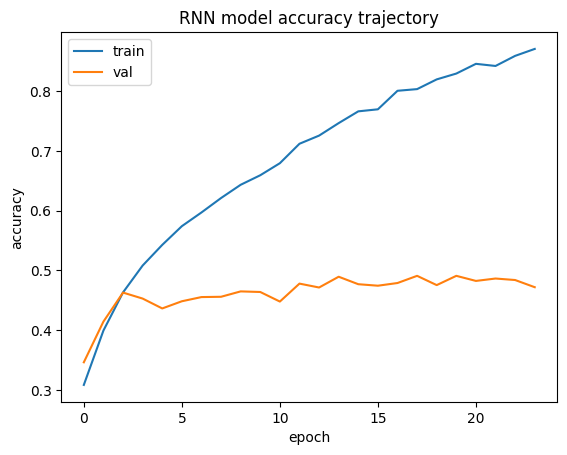

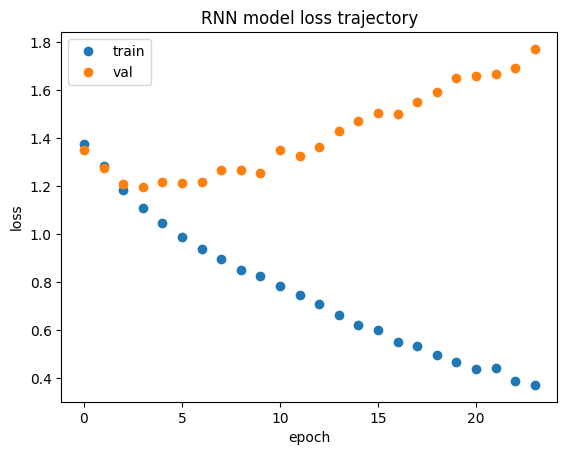

Test accuracy of the RNN model: 0.4898419976234436


In [7]:
# Plotting accuracy trajectory
plt.plot(rnn_model_results.history['accuracy'])
plt.plot(rnn_model_results.history['val_accuracy'])
plt.title('RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(rnn_model_results.history['loss'],'o')
plt.plot(rnn_model_results.history['val_loss'],'o')
plt.title('RNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
## Testing the RNN model

rnn_score = rnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the RNN model:',rnn_score[1])